In [1]:
#!/usr/bin/env python
# coding: utf-8

# #Predict the price of the Uber ride from a given pickup point to the agreed drop-off location. Perform following tasks:<br>
1.	Pre-process the dataset.<br>
2.	Identify outliers.<br>
3.	Check the correlation.<br>
4.	Implement linear regression and random forest regression models.<br>
5.	Evaluate the models and compare their respective scores like R2, RMSE, etc. Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset<br>


In[2]:

mporting the required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In[3]:

mporting the dataset

In [3]:
df  = pd.read_csv(r"D:\COLLEG_files\All_SEM_files\Sem_7\All_codes\LP_3\ML\uber.csv")

##  1.	Pre-process the dataset.

In[4]:

In [4]:
df.head()

df.info() #To get the required information of the dataset

df.columns #TO get number of columns in the dataset

df = df.drop(['Unnamed: 0', 'key'], axis= 1) #To drop unnamed column as it isn't required

df.head()

df.shape #To get the total (Rows,Columns)

df.dtypes #To get the type of each column

df.info()

df.describe() #To get statistics of each columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


### Filling Missing values

In [5]:
df.isnull().sum() 

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [6]:
df['dropoff_latitude'].fillna(value=df['dropoff_latitude'].mean(),inplace = True)
df['dropoff_longitude'].fillna(value=df['dropoff_longitude'].median(),inplace = True)

df.isnull().sum() 

df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Column pickup_datetime is in wrong format (Object). Convert it to DateTime Format

In [7]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce') 

df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

### To segregate each time of date and time

In [8]:
df= df.assign(hour = df.pickup_datetime.dt.hour,
             day= df.pickup_datetime.dt.day,
             month = df.pickup_datetime.dt.month,
             year = df.pickup_datetime.dt.year,
             dayofweek = df.pickup_datetime.dt.dayofweek)

df.head()

df = df.drop('pickup_datetime',axis=1)

df.head()

df.dtypes

fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
hour                   int32
day                    int32
month                  int32
year                   int32
dayofweek              int32
dtype: object

## 2. Checking outliers and filling them 

In[24]:

fare_amount             Axes(0.125,0.786098;0.352273x0.0939024)
pickup_longitude     Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_latitude         Axes(0.125,0.673415;0.352273x0.0939024)
dropoff_longitude    Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_latitude        Axes(0.125,0.560732;0.352273x0.0939024)
passenger_count      Axes(0.547727,0.560732;0.352273x0.0939024)
hour                    Axes(0.125,0.448049;0.352273x0.0939024)
day                  Axes(0.547727,0.448049;0.352273x0.0939024)
month                   Axes(0.125,0.335366;0.352273x0.0939024)
year                 Axes(0.547727,0.335366;0.352273x0.0939024)
dayofweek               Axes(0.125,0.222683;0.352273x0.0939024)
dist_travel_km       Axes(0.547727,0.222683;0.352273x0.0939024)
dtype: object

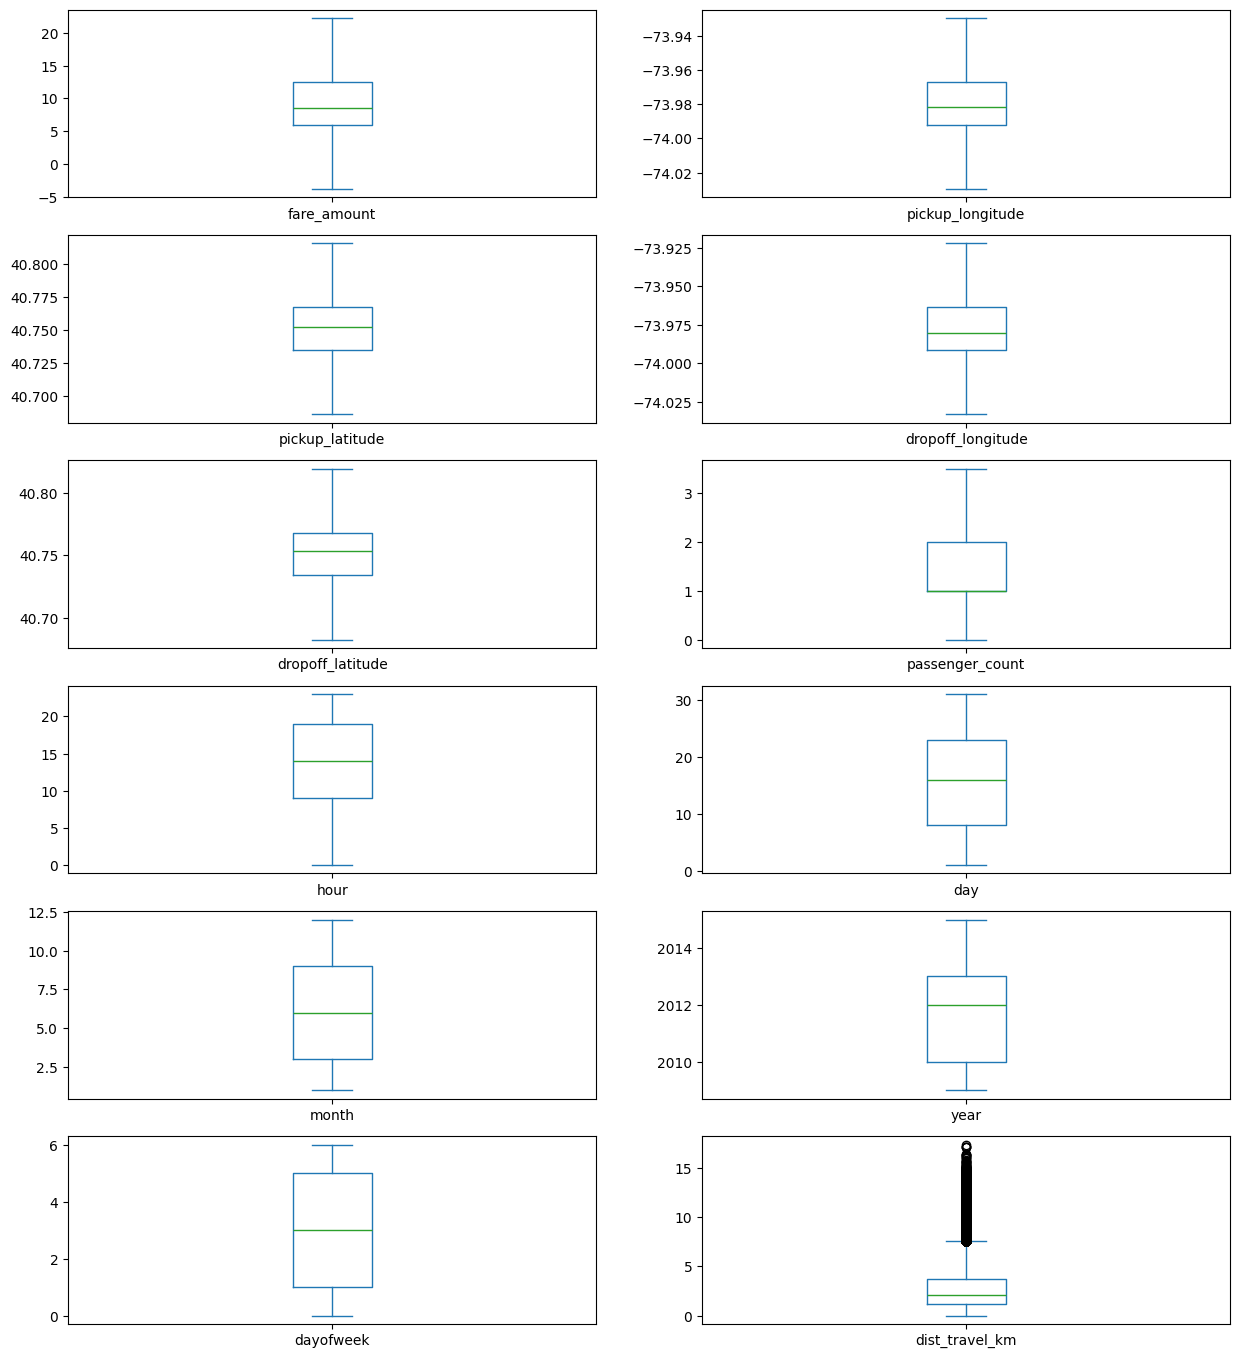

In [22]:
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) #Boxplot to check the outliers

#sing the InterQuartile Range to fill the values

In [10]:
def remove_outlier(df1 , col):
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df[col] = np.clip(df1[col] , lower_whisker , upper_whisker)
    return df1

In [11]:
def treat_outliers_all(df1 , col_list):
    for c in col_list:
        df1 = remove_outlier(df , c)
    return df1

In [12]:
df = treat_outliers_all(df , df.iloc[: , 0::])

fare_amount             Axes(0.125,0.786098;0.352273x0.0939024)
pickup_longitude     Axes(0.547727,0.786098;0.352273x0.0939024)
pickup_latitude         Axes(0.125,0.673415;0.352273x0.0939024)
dropoff_longitude    Axes(0.547727,0.673415;0.352273x0.0939024)
dropoff_latitude        Axes(0.125,0.560732;0.352273x0.0939024)
passenger_count      Axes(0.547727,0.560732;0.352273x0.0939024)
hour                    Axes(0.125,0.448049;0.352273x0.0939024)
day                  Axes(0.547727,0.448049;0.352273x0.0939024)
month                   Axes(0.125,0.335366;0.352273x0.0939024)
year                 Axes(0.547727,0.335366;0.352273x0.0939024)
dayofweek               Axes(0.125,0.222683;0.352273x0.0939024)
dtype: object

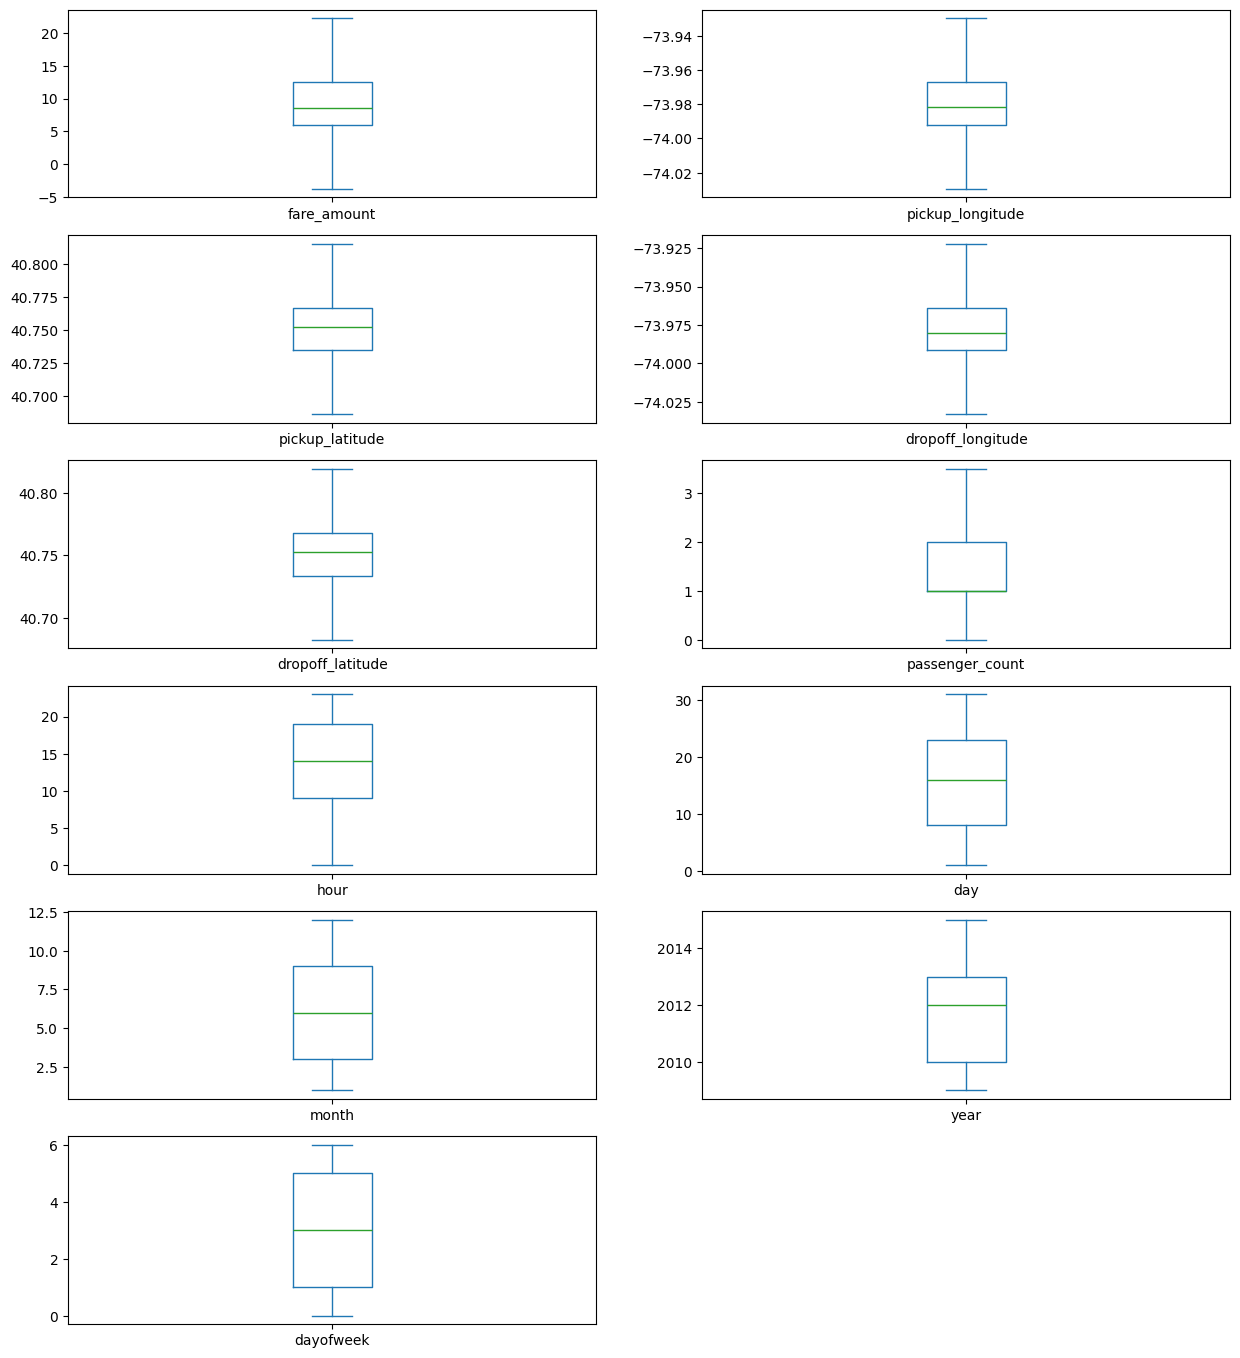

In [13]:
df.plot(kind = "box",subplots = True,layout = (7,2),figsize=(15,20)) #Boxplot shows that dataset is free from outliers

In [14]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [15]:
import haversine as hs  #Calculate the distance using Haversine to calculate the distance between to points. Can't use Eucladian as it is for flat surface.
travel_dist = []
for pos in range(len(df['pickup_longitude'])):
        long1,lati1,long2,lati2 = [df['pickup_longitude'][pos],df['pickup_latitude'][pos],df['dropoff_longitude'][pos],df['dropoff_latitude'][pos]]
        loc1=(lati1,long1)
        loc2=(lati2,long2)
        c = hs.haversine(loc1,loc2)
        travel_dist.append(c)
    
print(travel_dist)
df['dist_travel_km'] = travel_dist
df.head()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683325
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457593
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036384
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661686
4,16.0,-73.929786,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.116088


ber doesn't travel over 130 kms so minimize the distance 

Remaining observastions in the dataset: (200000, 12)


<Axes: >

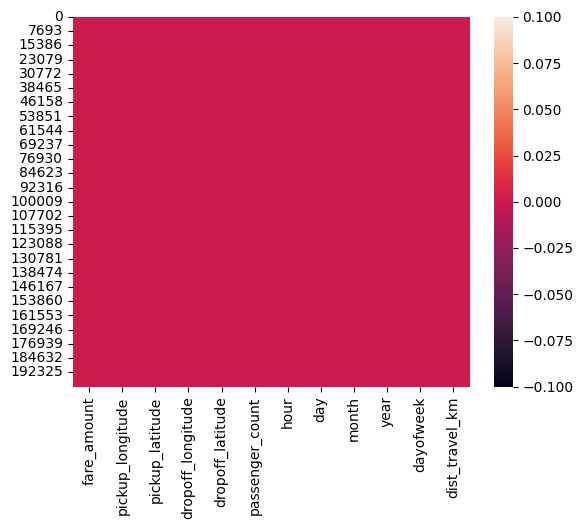

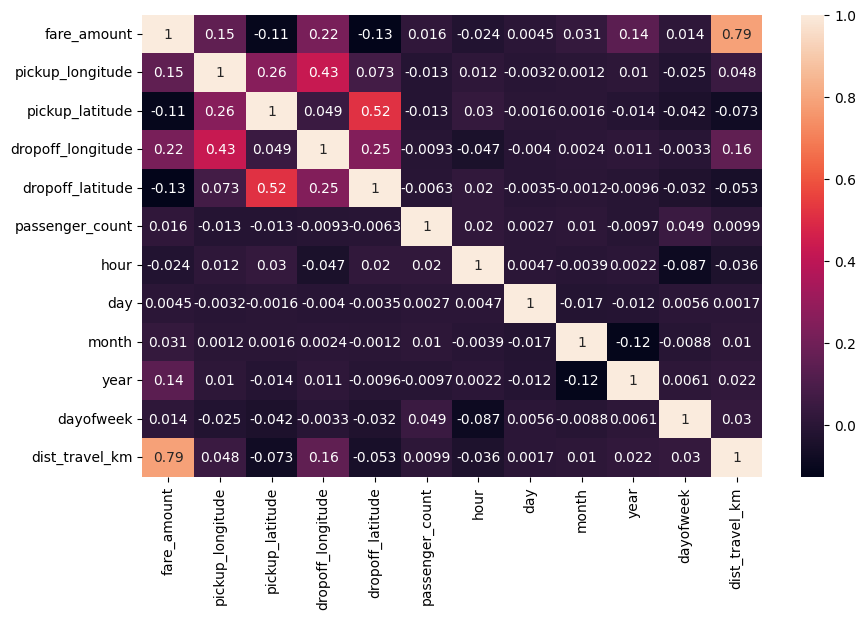

In [16]:
df= df.loc[(df.dist_travel_km >= 1) | (df.dist_travel_km <= 130)]
print("Remaining observastions in the dataset:", df.shape)

incorrect_coordinates = df.loc[(df.pickup_latitude > 90) |(df.pickup_latitude < -90) |
                                   (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) |
                                   (df.pickup_longitude > 180) |(df.pickup_longitude < -180) |
                                   (df.dropoff_longitude > 90) |(df.dropoff_longitude < -90)
                                    ]

df.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

df.head()

df.isnull().sum()

sns.heatmap(df.isnull()) #Free for null values

corr = df.corr() #Function to find the correlation

corr

fig,axis = plt.subplots(figsize = (10,6))
sns.heatmap(df.corr(),annot = True) #Correlation Heatmap (Light values means highly correlated)

### Dividing the dataset into feature and target values 

In [17]:
x = df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count','hour','day','month','year','dayofweek','dist_travel_km']]

y = df['fare_amount']

### Dividing the dataset into training and testing dataset

In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.33)

### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression
regression = LinearRegression()

regression.fit(X_train,y_train)

regression.intercept_ #To find the linear intercept

regression.coef_ #To find the linear coeeficient

prediction = regression.predict(X_test) #To predict the target values

print(prediction)

y_test

[ 7.8799894   6.37786444 23.54995837 ...  8.44641519  9.38514557
 12.10643276]


42654      9.30
194863     7.00
183563    22.25
125022     2.50
82586      9.50
          ...  
13655      6.10
63183     11.00
93294      7.30
196890     7.30
68700      9.00
Name: fare_amount, Length: 66000, dtype: float64

### Metrics Evaluation using R2, Mean Squared Error, Mean Absolute Error, Root Mean Sqared Error

In [20]:
from sklearn.metrics import r2_score 

r2_score(y_test,prediction)

from sklearn.metrics import mean_squared_error , mean_absolute_error

MSE = mean_squared_error(y_test,prediction)

print(MSE) 

MAE= mean_absolute_error(y_test, prediction)

print(MAE)

RMSE = np.sqrt(MSE)

print(RMSE)

9.825650854834649
2.135216185704295
3.1345894236462053


### Random Forest Regression

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100) #Here n_estimators means number of trees you want to build before making the prediction

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

y_pred

array([ 8.798 ,  6.6   , 22.0455, ...,  7.516 ,  8.042 , 10.355 ])

### Metrics evaluatin for Random Forest

In [24]:
R2_Random = r2_score(y_test,y_pred)

print(R2_Random)

MSE_Random = mean_squared_error(y_test,y_pred)

print(MSE_Random)

MAE_Random = mean_absolute_error(y_test,y_pred)

print(MAE_Random)

RMSE_Random = np.sqrt(MSE_Random)

print(RMSE_Random)

0.7998859604135923
5.961452241815172
1.5484221904761906
2.441608535743429
